# Downloading Dataset

In [ ]:
#!/bin/bash
!curl -L -o spoken-digit.zip https://www.kaggle.com/api/v1/datasets/download/joserzapata/free-spoken-digit-dataset-fsdd

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.5M  100 15.5M    0     0  5893k      0  0:00:02  0:00:02 --:--:-- 9523k


In [ ]:
!unzip spoken-digit.zip -d spoken-digit

Archive:  spoken-digit.zip
  inflating: spoken-digit/.gitignore  
  inflating: spoken-digit/README.md  
  inflating: spoken-digit/__init__.py  
  inflating: spoken-digit/acquire_data/say_numbers_prompt.py  
  inflating: spoken-digit/acquire_data/split_and_label_numbers.py  
  inflating: spoken-digit/metadata.py  
  inflating: spoken-digit/pip_requirements.txt  
  inflating: spoken-digit/recordings/0_george_0.wav  
  inflating: spoken-digit/recordings/0_george_1.wav  
  inflating: spoken-digit/recordings/0_george_10.wav  
  inflating: spoken-digit/recordings/0_george_11.wav  
  inflating: spoken-digit/recordings/0_george_12.wav  
  inflating: spoken-digit/recordings/0_george_13.wav  
  inflating: spoken-digit/recordings/0_george_14.wav  
  inflating: spoken-digit/recordings/0_george_15.wav  
  inflating: spoken-digit/recordings/0_george_16.wav  
  inflating: spoken-digit/recordings/0_george_17.wav  
  inflating: spoken-digit/recordings/0_george_18.wav  
  inflating: spoken-digit/recordi

# Loading & Splitting Dataset

In [ ]:
# prompt: Extract number of lables

import os

DATASET_PATH = "/content/spoken-digit/recordings"

def get_unique_labels(dataset_path):
    labels = set()
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".wav"):
            label = int(file_name.split("_")[0])
            labels.add(label)
    return labels

unique_labels = get_unique_labels(DATASET_PATH)
num_labels = len(unique_labels)

print(f"Number of unique labels: {num_labels}")

Number of unique labels: 10


In [ ]:
import os
import torch
import torchaudio
from sklearn.model_selection import train_test_split
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

# Path to the dataset
DATASET_PATH = "/content/spoken-digit/recordings"

# Audio processing parameters
SAMPLE_RATE = 16000
N_MELS = 80
N_FFT = 400
HOP_LENGTH = 200

# Transformation pipeline
mel_transform = MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
)
db_transform = AmplitudeToDB()

def preprocess_audio(file_path):
    """
    Load an audio file and convert it to a Log-Mel spectrogram.
    """
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
        waveform = resampler(waveform)
    mel_spec = mel_transform(waveform)  # Shape: (1, n_mels, time_steps)
    log_mel_spec = db_transform(mel_spec)  # Convert to dB
    return log_mel_spec.squeeze(0)  # Shape: (n_mels, time_steps)

def load_dataset(dataset_path):
    """
    Parse filenames, preprocess audio, and split into train/val/test sets.
    """
    data = []
    labels = []

    # Loop through files in the dataset
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".wav"):
            # Extract label from filename (e.g., "7_jackson_32.wav" -> label=7)
            label = int(file_name.split("_")[0])
            file_path = os.path.join(dataset_path, file_name)

            # Preprocess the audio
            mel_spec = preprocess_audio(file_path)

            # Add to dataset
            data.append(mel_spec)
            labels.append(label)

    # Split into train, validation, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=0.4, random_state=42
    )
    val_data, test_data, val_labels, test_labels = train_test_split(
        test_data, test_labels, test_size=0.5, random_state=42
    )

    return {
        "train": (train_data, train_labels),
        "val": (val_data, val_labels),
        "test": (test_data, test_labels),
    }

# Load the dataset
dataset = load_dataset(DATASET_PATH)

# Example of dataset structure
print(f"Train samples: {len(dataset['train'][0])}")
print(f"Validation samples: {len(dataset['val'][0])}")
print(f"Test samples: {len(dataset['test'][0])}")

Train samples: 1800
Validation samples: 600
Test samples: 600


# Creating Training Dataset

In [ ]:
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class SpokenDigitsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mel_spec = self.data[idx]
        label = self.labels[idx]

        # Ensure tensors are returned
        return mel_spec.clone().detach(), torch.tensor(label, dtype=torch.long)
        #return torch.tensor(mel_spec, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    """
    Pads the Mel spectrograms in a batch to have the same length.
    """
    mel_specs, labels = zip(*batch)  # Unzip the batch

    # Calculate the maximum length along time dimension
    max_len = max(mel_spec.shape[1] for mel_spec in mel_specs)

    # Pad the Mel spectrograms to the maximum length
    mel_specs_padded = [torch.nn.functional.pad(mel_spec, (0, max_len - mel_spec.shape[1]), value=0) for mel_spec in mel_specs]
    mel_specs_padded = torch.stack(mel_specs_padded, dim=0)  # Stack into a batch

    # Stack the labels
    labels = torch.stack(labels)

    return mel_specs_padded, labels

# Create datasets
train_dataset = SpokenDigitsDataset(*dataset["train"])
val_dataset = SpokenDigitsDataset(*dataset["val"])
test_dataset = SpokenDigitsDataset(*dataset["test"])

# DataLoaders for batching
from torch.utils.data import DataLoader

# Create DataLoaders with the custom collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

# Model Implemetation

In [ ]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        # x: (batch_size, time_steps, d_model)
        seq_len = x.size(1)
        return x + self.encoding[:, :seq_len, :].to(x.device)

In [ ]:
import torch.nn as nn

class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=4, dim_feedforward=256, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x, mask=None):
        # x: (batch_size, time_steps, d_model)
        x = x.permute(1, 0, 2)  # (time_steps, batch_size, d_model)
        x = self.encoder(x, src_key_padding_mask=mask)  # (time_steps, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, time_steps, d_model)
        return x

In [ ]:
class SpokenNumberRecognizer(nn.Module):
    def __init__(self, num_classes=10, d_model=128, nhead=8, num_layers=4, max_len=5000):
        super().__init__()
        self.conv1d = nn.Sequential(
            nn.Conv1d(80, d_model, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
        )
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)
        self.encoder = TransformerEncoderBlock(d_model=d_model, nhead=nhead, num_layers=num_layers)
        self.pooling = nn.AdaptiveAvgPool1d(1)  # Aggregate over time steps
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        # Input: (batch_size, 80, time_steps)
        x = self.conv1d(x)  # (batch_size, d_model, time_steps)
        x = x.permute(0, 2, 1)  # (batch_size, time_steps, d_model)
        x = self.positional_encoding(x)  # Add positional encoding
        x = self.encoder(x, mask=mask)  # Transformer Encoder
        x = x.permute(0, 2, 1)  # (batch_size, d_model, time_steps)
        x = self.pooling(x).squeeze(-1)  # (batch_size, d_model)
        logits = self.fc(x)  # (batch_size, num_classes)
        return logits

# Training Phase

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SpokenNumberRecognizer(num_classes=10).to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_accuracy = 0.0
epochs_no_improve = 0

# Lists to store accuracy and loss for plotting
train_acc_history = []
val_acc_history = []
train_loss_history = []

# Training loop
for epoch in range(50):  # Increase the number of epochs
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for mel_specs, labels in train_loader:
        mel_specs, labels = mel_specs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel_specs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for mel_specs, labels in val_loader:
            mel_specs, labels = mel_specs.to(device), labels.to(device)
            outputs = model(mel_specs)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val * 100
    val_acc_history.append(val_accuracy)

    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save the best model
    else:
        epochs_no_improve += 1
        print(f"Early stopping counter: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Load the best model for evaluation
model.load_state_dict(best_model_state)

Epoch 1, Loss: 2.3047, Train Accuracy: 11.22%
Validation Accuracy: 22.33%
Epoch 2, Loss: 2.1883, Train Accuracy: 22.67%
Validation Accuracy: 22.17%
Early stopping counter: 1/5
Epoch 3, Loss: 1.9759, Train Accuracy: 31.78%
Validation Accuracy: 41.50%
Epoch 4, Loss: 1.7785, Train Accuracy: 40.78%
Validation Accuracy: 53.33%
Epoch 5, Loss: 1.6234, Train Accuracy: 53.33%
Validation Accuracy: 55.33%
Epoch 6, Loss: 1.4824, Train Accuracy: 60.22%
Validation Accuracy: 67.83%
Epoch 7, Loss: 1.3685, Train Accuracy: 66.28%
Validation Accuracy: 70.33%
Epoch 8, Loss: 1.2777, Train Accuracy: 70.33%
Validation Accuracy: 69.50%
Early stopping counter: 1/5
Epoch 9, Loss: 1.2065, Train Accuracy: 74.56%
Validation Accuracy: 79.00%
Epoch 10, Loss: 1.1290, Train Accuracy: 77.89%
Validation Accuracy: 84.17%
Epoch 11, Loss: 1.0169, Train Accuracy: 84.67%
Validation Accuracy: 80.83%
Early stopping counter: 1/5
Epoch 12, Loss: 0.9660, Train Accuracy: 84.06%
Validation Accuracy: 85.83%
Epoch 13, Loss: 0.9115, T

<All keys matched successfully>

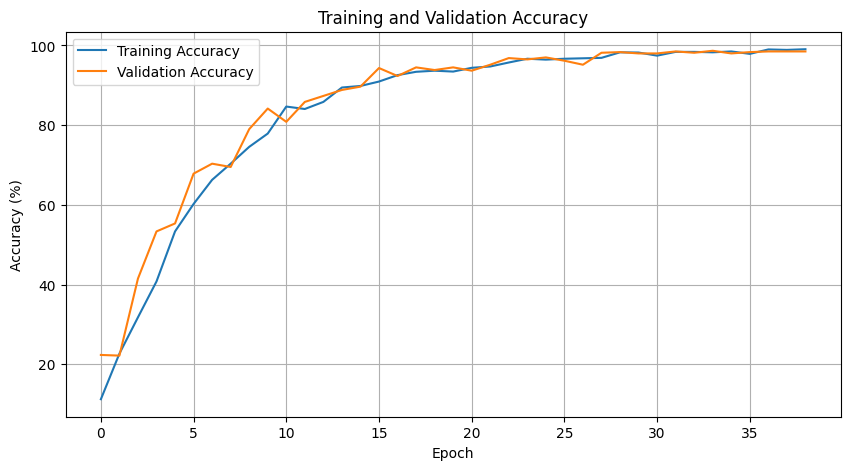

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# Evaluation

In [ ]:
# Test evaluation
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for mel_specs, labels in test_loader:
        mel_specs, labels = mel_specs.to(device), labels.to(device)
        outputs = model(mel_specs)
        _, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.50%


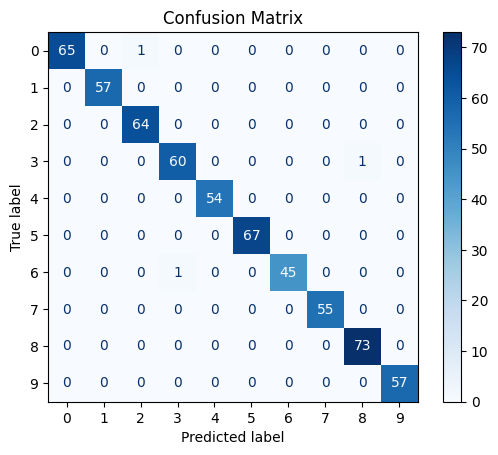

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model on the test set and collect predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for mel_specs, labels in test_loader:
        mel_specs, labels = mel_specs.to(device), labels.to(device)
        outputs = model(mel_specs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Noise Sensitivity

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Function to add white noise to a signal
def add_white_noise(signal, snr_db):
    """
    Adds white noise to the signal at a specified SNR.
    :param signal: Input signal (numpy array).
    :param snr_db: Desired Signal-to-Noise Ratio in dB.
    :return: Noisy signal.
    """
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

# Evaluate model performance at different SNR levels
snr_levels = [-10, -5, 0, 5, 10, 15, 20]  # Example SNR values in dB
accuracy_snr = []

for snr in snr_levels:
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for mel_specs, labels in test_loader:
            # Add white noise to the test data
            noisy_mel_specs = torch.tensor(
                [add_white_noise(mel.numpy(), snr) for mel in mel_specs],
                dtype=torch.float32
            ).to(device)

            labels = labels.to(device)
            outputs = model(noisy_mel_specs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    accuracy_snr.append(acc)
    print(f"SNR: {snr} dB, Accuracy: {acc * 100:.2f}%")

<ipython-input-13-307dec597625>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  noisy_mel_specs = torch.tensor(


SNR: -10 dB, Accuracy: 19.17%
SNR: -5 dB, Accuracy: 29.50%
SNR: 0 dB, Accuracy: 49.33%
SNR: 5 dB, Accuracy: 80.50%
SNR: 10 dB, Accuracy: 92.00%
SNR: 15 dB, Accuracy: 96.83%
SNR: 20 dB, Accuracy: 98.33%


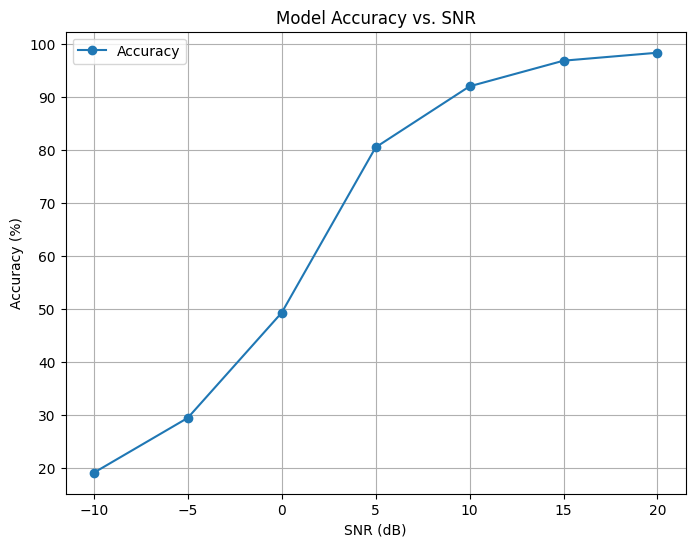

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(snr_levels, [acc * 100 for acc in accuracy_snr], marker="o", label="Accuracy")
plt.title("Model Accuracy vs. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# Noise Robustness

In [ ]:
import os
import torch
import torchaudio
from sklearn.model_selection import train_test_split
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
import math
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import accuracy_score


# Data augmentation function
def augment_data(data, labels, snr_db_min=-20, snr_db_max=20, num_augmented=1):
  augmented_data = []
  augmented_labels = []
  for i, (signal, label) in enumerate(zip(data, labels)):
    augmented_data.append(signal)  # Original signal
    augmented_labels.append(label)

    for _ in range(num_augmented):
      snr = np.random.uniform(snr_db_min, snr_db_max)
      noise = np.random.normal(0, np.sqrt(np.mean(signal.numpy()**2) / (10**(snr / 10))), signal.shape)
      noisy_signal = signal + torch.tensor(noise, dtype=torch.float32)
      augmented_data.append(noisy_signal)
      augmented_labels.append(label)

  return augmented_data, augmented_labels

# Augment the training & Validation data
augmented_train_data, augmented_train_labels = augment_data(dataset["train"][0], dataset["train"][1], num_augmented=20)
augmented_val_data, augmented_val_labels = augment_data(dataset["val"][0], dataset["val"][1], num_augmented=5)



# Create the augmented dataset
train_dataset = SpokenDigitsDataset(augmented_train_data, augmented_train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataset = SpokenDigitsDataset(augmented_val_data, augmented_val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SpokenNumberRecognizer(num_classes=10).to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_accuracy = 0.0
epochs_no_improve = 0

# Lists to store accuracy and loss for plotting
train_acc_history = []
val_acc_history = []
train_loss_history = []

# Training loop
for epoch in range(100):  # Increase the number of epochs
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for mel_specs, labels in train_loader:
        mel_specs, labels = mel_specs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(mel_specs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for mel_specs, labels in val_loader:
            mel_specs, labels = mel_specs.to(device), labels.to(device)
            outputs = model(mel_specs)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val * 100
    val_acc_history.append(val_accuracy)

    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save the best model
    else:
        epochs_no_improve += 1
        print(f"Early stopping counter: {epochs_no_improve}/{patience}")
        if epochs_no_improve >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Load the best model for evaluation
model.load_state_dict(best_model_state)

Epoch 1, Loss: 2.1534, Train Accuracy: 19.39%
Validation Accuracy: 29.28%
Epoch 2, Loss: 1.7291, Train Accuracy: 39.02%
Validation Accuracy: 45.53%
Epoch 3, Loss: 1.4210, Train Accuracy: 53.43%
Validation Accuracy: 55.28%
Epoch 4, Loss: 1.2182, Train Accuracy: 60.98%
Validation Accuracy: 62.56%
Epoch 5, Loss: 1.0866, Train Accuracy: 65.53%
Validation Accuracy: 65.94%
Epoch 6, Loss: 0.9947, Train Accuracy: 68.29%
Validation Accuracy: 67.19%
Epoch 7, Loss: 0.9318, Train Accuracy: 70.34%
Validation Accuracy: 67.78%
Epoch 8, Loss: 0.8839, Train Accuracy: 71.35%
Validation Accuracy: 69.78%
Epoch 9, Loss: 0.8428, Train Accuracy: 72.56%
Validation Accuracy: 68.53%
Early stopping counter: 1/10
Epoch 10, Loss: 0.8129, Train Accuracy: 73.49%
Validation Accuracy: 70.36%
Epoch 11, Loss: 0.7884, Train Accuracy: 74.09%
Validation Accuracy: 70.97%
Epoch 12, Loss: 0.7638, Train Accuracy: 74.43%
Validation Accuracy: 71.83%
Epoch 13, Loss: 0.7452, Train Accuracy: 75.28%
Validation Accuracy: 71.50%
Early

<All keys matched successfully>

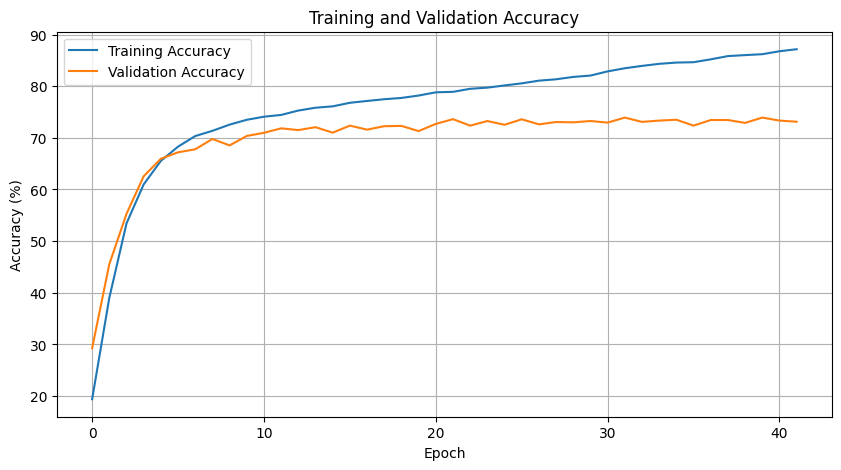

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

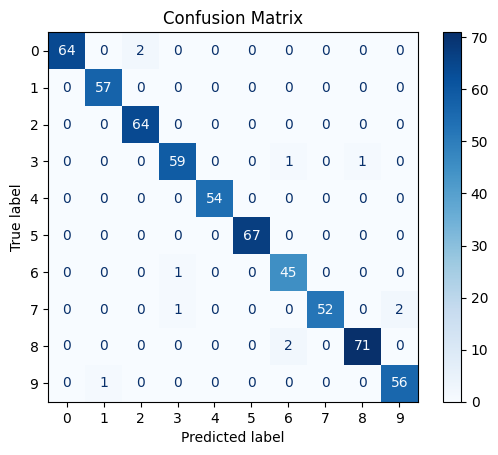

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model on the test set and collect predictions and true labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for mel_specs, labels in test_loader:
        mel_specs, labels = mel_specs.to(device), labels.to(device)
        outputs = model(mel_specs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Function to add white noise to a signal
def add_white_noise(signal, snr_db):
    """
    Adds white noise to the signal at a specified SNR.
    :param signal: Input signal (numpy array).
    :param snr_db: Desired Signal-to-Noise Ratio in dB.
    :return: Noisy signal.
    """
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

# Evaluate model performance at different SNR levels
snr_levels = [-10, -5, 0, 5, 10, 15, 20]  # Example SNR values in dB
snr_levels = [x for x in range(-100, 100, 5)]
accuracy_snr = []

for snr in snr_levels:
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for mel_specs, labels in test_loader:
            # Add white noise to the test data
            noisy_mel_specs = torch.tensor(
                [add_white_noise(mel.numpy(), snr) for mel in mel_specs],
                dtype=torch.float32
            ).to(device)

            labels = labels.to(device)
            outputs = model(noisy_mel_specs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    accuracy_snr.append(acc)
    print(f"SNR: {snr} dB, Accuracy: {acc * 100:.2f}%")

SNR: -30 dB, Accuracy: 10.33%
SNR: -25 dB, Accuracy: 11.83%
SNR: -20 dB, Accuracy: 13.83%
SNR: -15 dB, Accuracy: 21.33%
SNR: -10 dB, Accuracy: 39.67%
SNR: -5 dB, Accuracy: 71.83%
SNR: 0 dB, Accuracy: 89.83%
SNR: 5 dB, Accuracy: 96.67%


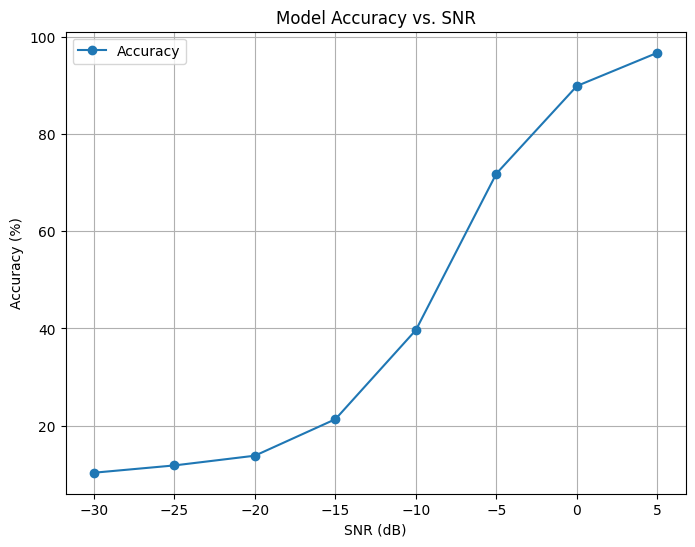

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(snr_levels, [acc * 100 for acc in accuracy_snr], marker="o", label="Accuracy")
plt.title("Model Accuracy vs. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()